In [1]:
from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *


import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


Button(button_style='success', description='Save Situation', style=ButtonStyle())

Button(button_style='warning', description='Clear', style=ButtonStyle())

Button(button_style='info', description='Toggle Draw Vector', style=ButtonStyle())

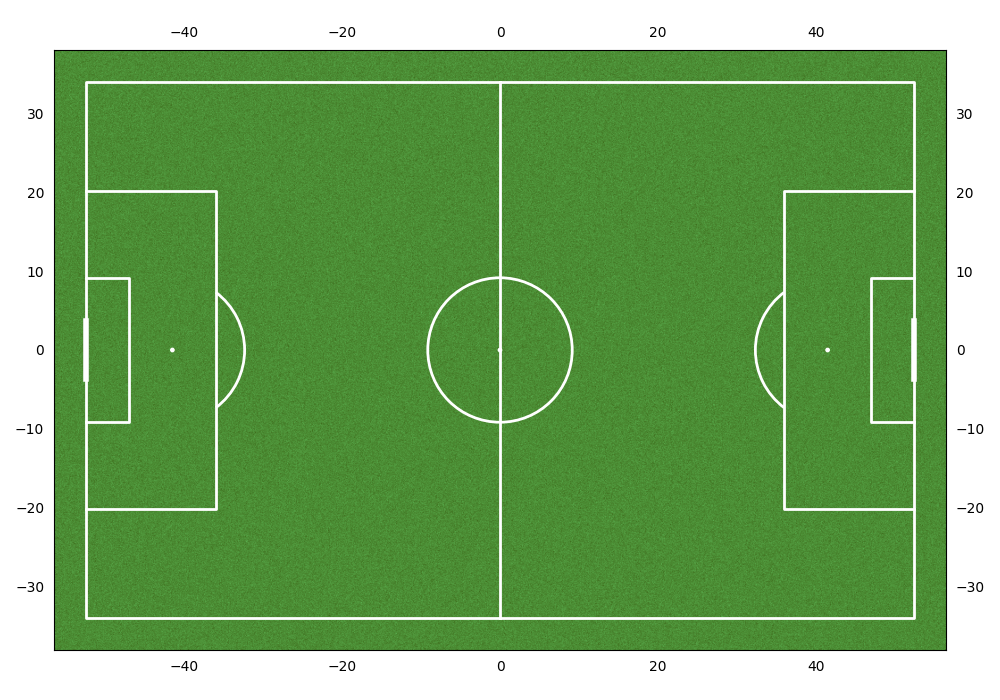

Situation saved! Total saved situations: 1


In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import ipywidgets as widgets
from IPython.display import display

# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation and vectors
points = []
vectors = []
situations = []

# Boolean to check if we're in vector drawing mode
draw_vector_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points and vectors
def on_click(event):
    global vector_start, draw_vector_mode
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point
        
        plt.draw()  # Redraw the figure

# Function to save the current situation
def save_situation(_):
    if points or vectors:
        situations.append({'points': list(points), 'vectors': list(vectors)})  # Save the current points and vectors
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players or vectors to save!")

# Function to clear the current situation
def clear_situation(_):
    global points, vectors, vector_start
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    vector_start = None  # Reset vector start point
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. You can now draw a new one.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

# Create save, clear, and toggle vector buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')

# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)

# Display the buttons below the plot
display(save_button, clear_button, toggle_vector_button)

# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()


In [10]:
situations

[{'points': [(np.float64(8.404260459302066), np.float64(14.021219765128627)),
   (np.float64(8.404260459302066), np.float64(14.021219765128627)),
   (np.float64(8.404260459302066), np.float64(14.021219765128627)),
   (np.float64(8.911050044452182), np.float64(5.152402025001557)),
   (np.float64(10.051326611039954), np.float64(-6.757153226026226)),
   (np.float64(-6.92612449148902), np.float64(7.9397447433272035)),
   (np.float64(-7.3062166803516035), np.float64(-1.1824677893749254)),
   (np.float64(-23.016693820005273), np.float64(18.202233842617098)),
   (np.float64(-19.215771931379386), np.float64(1.9849671178133121)),
   (np.float64(-24.410365179168103), np.float64(-11.82504907752741)),
   (np.float64(-34.672854278458), np.float64(7.179560365602029)),
   (np.float64(-34.29276208959541), np.float64(-2.0693495633876324)),
   (np.float64(40.965491305197176), np.float64(0.08450617350037248))],
  'vectors': []}]

Collected 13 points.


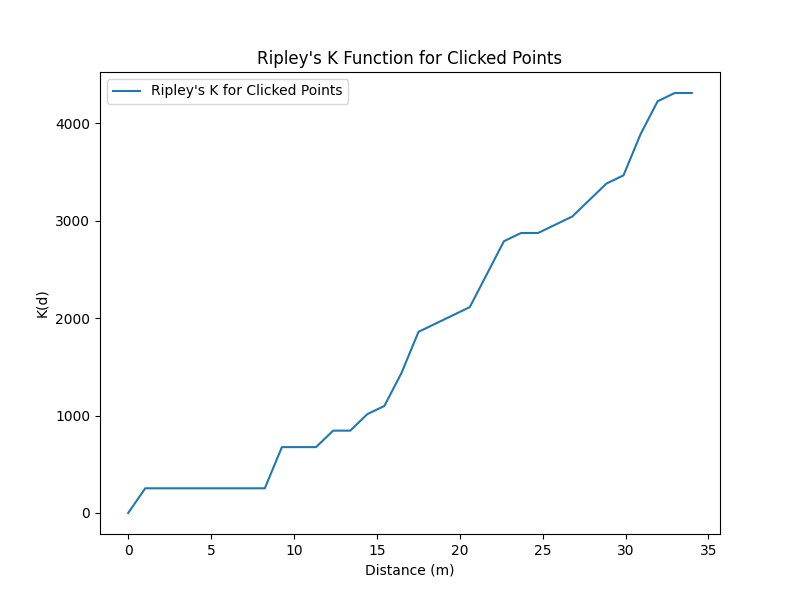

In [11]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())

    # Step 3: Define the radii for Ripley's K
    radii = np.linspace(0, 34, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [12]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
one_match = extract_one_match(data, 1)



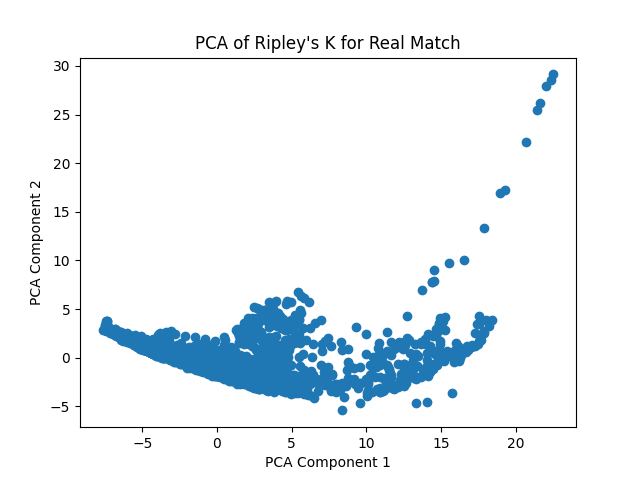

In [13]:
# Step 7: Calculate Ripley's K values for the real match data
ripley_k_vals = ripley_k_by_indices(one_match, one_match.iloc[::48].index)

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_vals, 10)  # Fit PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals)

# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

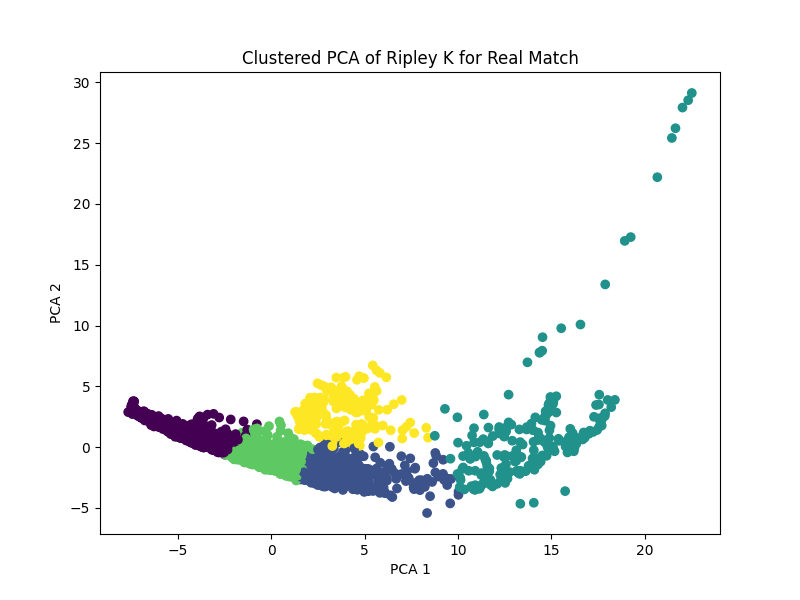

In [14]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

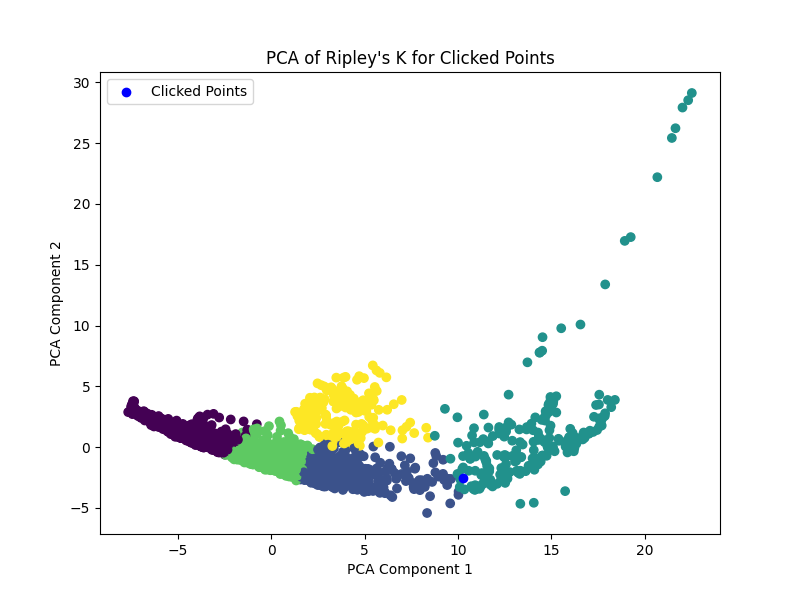

In [15]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    k_values_clicked = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [16]:
from sklearn.neighbors import KDTree

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [2205 1152 2478 2477 1635 2323 2325 2203 2324 2569]


In [17]:
# Assuming `one_match` is a DataFrame where each row contains player positions for a specific situation
# Each row of `one_match` contains the player positions in the format: [(x1, y1), (x2, y2), ...]

# Retrieve the 10 closest situations from the real match
closest_situations = one_match.iloc[closest_indices]


In [18]:
closest_situations

,Time [s]_team,half_team,minute_team,Period_team,home_6_x,home_6_y,home_18_x,home_18_y,home_1_x,home_1_y,...,away_5_y,away_14_x,away_14_y,away_23_x,away_23_y,away_19_x,away_19_y,ball_x,ball_y,ball_z
2205,88.20,1H,1,1,-13.048425,8.036766,-38.127869,27.382595,26.532261,0.511524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-36.081126,9.638126,0.549601
1152,46.08,1H,0,1,7.479365,2.652596,-5.577068,31.692629,36.883656,0.346142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.930934,2.579491,0.205593
2478,99.12,1H,1,1,-2.314839,-4.655120,-26.145842,8.450040,29.837404,-1.599247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.911223,-19.367371,0.527408
2477,99.08,1H,1,1,-2.359298,-4.639320,-26.128893,8.440152,29.847698,-1.586527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.953273,-19.999336,0.575076
1635,65.40,1H,1,1,-2.591917,-1.975249,-17.066420,28.861490,30.874495,-0.281679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.974298,7.256282,0.190548
2323,92.92,1H,1,1,-6.243751,5.807092,-22.131344,18.886965,29.415279,0.557192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.674810,-1.069392,0.255272
2325,93.00,1H,1,1,-6.031148,5.636755,-22.008230,18.646988,29.507345,0.513415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.282135,-1.319040,0.264040
2203,88.12,1H,1,1,-13.035092,8.014821,-38.133110,27.365450,26.588789,0.542305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35.909242,10.523699,0.899835
2324,92.96,1H,1,1,-6.135758,5.720614,-22.063128,18.766510,29.463093,0.534056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-17.481977,-1.189986,0.269103
2569,102.76,1H,1,1,-2.302194,-0.466363,-23.158466,16.757648,30.902185,-0.598922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.836938,8.197319,0.234909


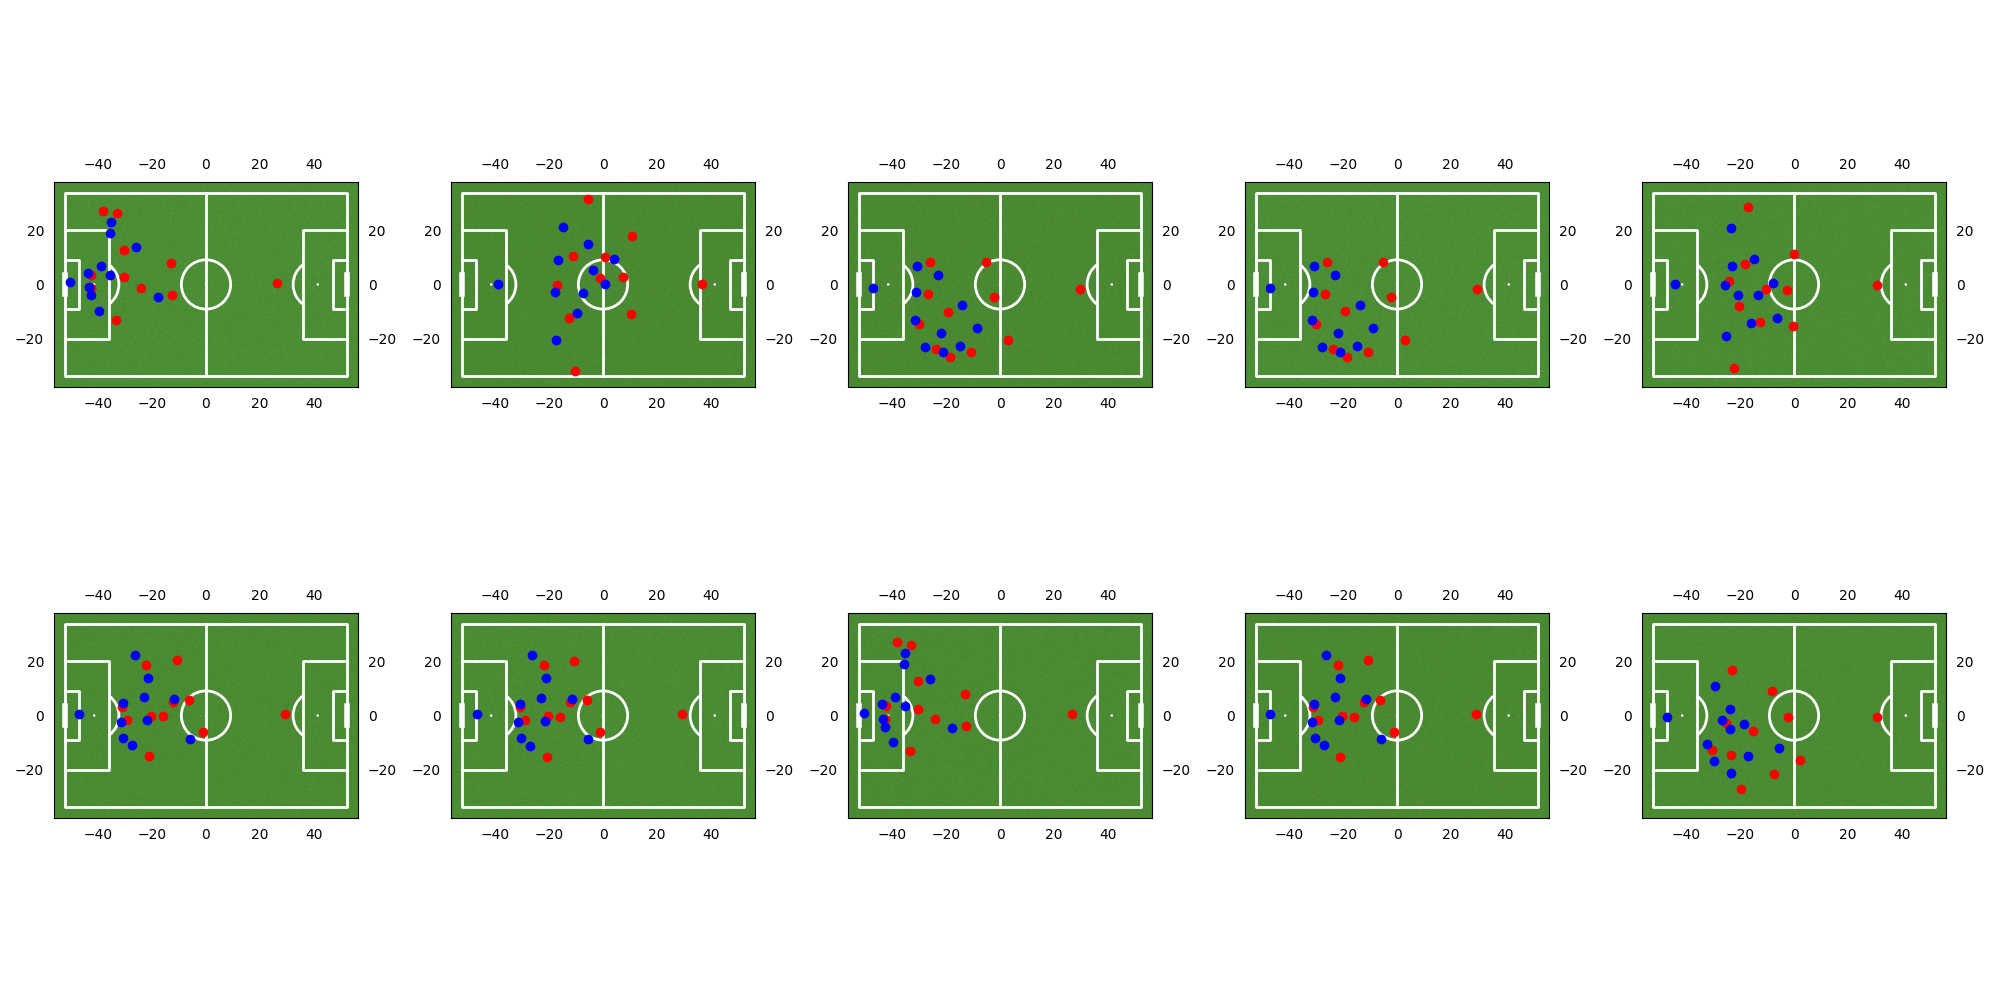

In [19]:
# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro')  # Mark home players as red dots

    # Plot away team players (blue)
    for pos in away_positions:
        ax.plot(pos[0], pos[1], 'bo')  # Mark away players as blue dots

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()

# Iterate over the 10 closest situations and plot them
for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
    plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation

plt.tight_layout()
plt.show()
